In [12]:
from time import time
import pandas as pd
import numpy as np
import re
import sys
import csv
csv.field_size_limit(sys.maxsize)

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import itertools
import datetime

import pprint
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

[nltk_data] Downloading package punkt to /Users/marco/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/marco/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /Users/marco/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
train = pd.read_csv('../writeups.csv', header=0)
train = train.applymap(lambda x: x.strip() if isinstance(x, str) else x)

nRow, nCol = train.shape
print(f'There are {nRow} rows and {nCol} columns in the training set')

# Removing empty rows from csv 
train.dropna(axis=0, how='all',inplace=True)
nRow, nCol = train.shape
print(f'There are {nRow} rows and {nCol} columns in the training set after removing empty rows')

train.head()

There are 147 rows and 4 columns in the training set
There are 147 rows and 4 columns in the training set after removing empty rows


,Writeup_name,Category,Text,Label
0,XMarkTheSpot,web,"Visiting the website, we are presented with a ...",overview
1,XMarkTheSpot,web,The idea is similar to SQL injection. \nWe hav...,analysis
2,XMarkTheSpot,web,"For example, let's inject:\nThis should tell u...",attack_execution
3,Members,web,"In the challenge members, we need to get more ...",overview
4,Members,web,"If we leave the search query empty, we would s...",analysis


In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147 entries, 0 to 146
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Writeup_name  147 non-null    object
 1   Category      147 non-null    object
 2   Text          147 non-null    object
 3   Label         147 non-null    object
dtypes: object(4)
memory usage: 4.7+ KB


In [15]:
train.isnull().sum()

Writeup_name    0
Category        0
Text            0
Label           0
dtype: int64

In [16]:
train = train[train['Text'].notna()]

nRow, nCol = train.shape
print(f'There are {nRow} rows and {nCol} columns in the training set after removing empty "text" columns')

train.head()

There are 147 rows and 4 columns in the training set after removing empty "text" columns


,Writeup_name,Category,Text,Label
0,XMarkTheSpot,web,"Visiting the website, we are presented with a ...",overview
1,XMarkTheSpot,web,The idea is similar to SQL injection. \nWe hav...,analysis
2,XMarkTheSpot,web,"For example, let's inject:\nThis should tell u...",attack_execution
3,Members,web,"In the challenge members, we need to get more ...",overview
4,Members,web,"If we leave the search query empty, we would s...",analysis


In [17]:
train.isnull().sum()

train.to_csv(r'train_before_preproc.csv', index=False, header=True)

# Pre-Processing Steps:

- Expand contractions
- Noise cleaning
- Remove stopwords

In [18]:
# Contraction Mapping

!pip install contractions
import contractions

## Expand Contractions

In [19]:
train = train[~train['Text'].str.contains("\n")]

nRow, nCol = train.shape
print(f'There are {nRow} rows and {nCol} columns in the training set after removing /n')

train.head()

train.to_csv(r'train_after_preproc.csv', index=False, header=True)

There are 57 rows and 4 columns in the training set after removing /n


In [20]:
train['Text'] = train['Text'].apply(lambda x: [contractions.fix(word) for word in x.split(' ')])

In [21]:
train.head()

,Writeup_name,Category,Text,Label
4,Members,web,"[If, we, leave, the, search, query, empty,, we...",analysis
9,High_Security,web,"[We, have, again, a, login, page., This, time,...",overview
12,27_Forbidden_Paths,web,"[This, website, has, the, useful, feature, of,...",overview
13,27_Forbidden_Paths,web,"[With, file, paths,, a, preceeding, ./, means,...",analysis
14,27_Forbidden_Paths,web,"[Since, we, know, that, we, are, in, /usr/shar...",attack_execution


In [22]:
#joining back the list of items into one string
train['Text'] = [' '.join(map(str, l)) for l in train['Text']]

In [23]:
train.head()

,Writeup_name,Category,Text,Label
4,Members,web,"If we leave the search query empty, we would s...",analysis
9,High_Security,web,"We have again a login page. This time only, we...",overview
12,27_Forbidden_Paths,web,This website has the useful feature of reading...,overview
13,27_Forbidden_Paths,web,"With file paths, a preceeding ./ means the cur...",analysis
14,27_Forbidden_Paths,web,Since we know that we are in /usr/share/nginx/...,attack_execution


 ## Noise Cleaning

In [71]:
# Noise Cleaning - spacing, special characters, lowercasing 
import regex as re

train['Text'] = train['Text'].str.lower()
train['Text'] = train['Text'].apply(lambda x: re.sub(r'[^\w\d\s\']+', '', x))

train.head()

,Writeup_name,Category,Text,Label
4,Members,web,if we leave the search query empty we would se...,analysis
9,High_Security,web,we have again a login page this time only we c...,overview
12,27_Forbidden_Paths,web,this website has the useful feature of reading...,overview
13,27_Forbidden_Paths,web,with file paths a preceeding means the curren...,analysis
14,27_Forbidden_Paths,web,since we know that we are in usrsharenginxhtml...,attack_execution


In [72]:
#nltk tokenization

train['Text_tokenize'] = train['Text'].apply(word_tokenize)

train.head()

,Writeup_name,Category,Text,Label,Text_tokenize
4,Members,web,if we leave the search query empty we would se...,analysis,"[if, we, leave, the, search, query, empty, we,..."
9,High_Security,web,we have again a login page this time only we c...,overview,"[we, have, again, a, login, page, this, time, ..."
12,27_Forbidden_Paths,web,this website has the useful feature of reading...,overview,"[this, website, has, the, useful, feature, of,..."
13,27_Forbidden_Paths,web,with file paths a preceeding means the curren...,analysis,"[with, file, paths, a, preceeding, means, the,..."
14,27_Forbidden_Paths,web,since we know that we are in usrsharenginxhtml...,attack_execution,"[since, we, know, that, we, are, in, usrsharen..."


In [73]:
# initializing Stop words libraries

nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /Users/marco/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [74]:
# Before removing checking occurances of stopwords in article content

%matplotlib inline
from matplotlib import pyplot as plt

def plot_top_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    from collections import defaultdict
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]
    x,y=zip(*top)
    plt.figure(figsize=(10,10))
    plt.bar(x,y)

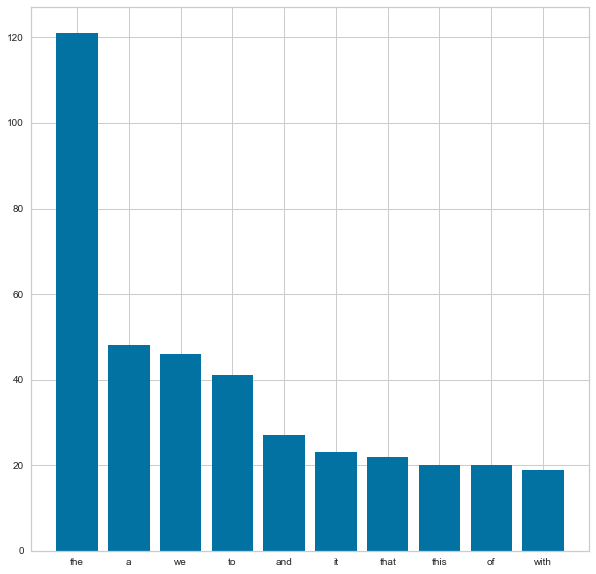

In [75]:
plot_top_stopwords_barchart(train['Text'])

train.to_csv(r'train_after_noise.csv', index=False, header=True)

In [76]:
import seaborn as sns
from collections import  Counter

def plot_top_non_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:50]:
        if (word not in stop):
            x.append(word)
            y.append(count)
    plt.figure(figsize=(10,10))
    sns.barplot(x=y,y=x)

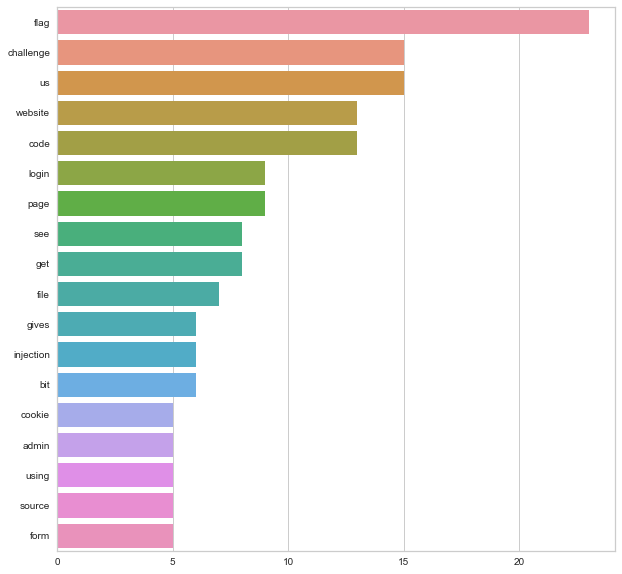

In [77]:
plot_top_non_stopwords_barchart(train['Text'])

## Remove Stopwords

In [78]:
# Now we remove stopwords 

train['Text_tokenize'] = train['Text_tokenize'].apply(lambda x: [word for word in x if word not in stop_words])
train['Text_tokenize_join'] = [' '.join(map(str, l)) for l in train['Text_tokenize']]

train.head()

,Writeup_name,Category,Text,Label,Text_tokenize,Text_tokenize_join
4,Members,web,if we leave the search query empty we would se...,analysis,"[leave, search, query, empty, would, see, memb...",leave search query empty would see members els...
9,High_Security,web,we have again a login page this time only we c...,overview,"[login, page, time, register, user]",login page time register user
12,27_Forbidden_Paths,web,this website has the useful feature of reading...,overview,"[website, useful, feature, reading, file, want...",website useful feature reading file want given...
13,27_Forbidden_Paths,web,with file paths a preceeding means the curren...,analysis,"[file, paths, preceeding, means, current, dire...",file paths preceeding means current directory ...
14,27_Forbidden_Paths,web,since we know that we are in usrsharenginxhtml...,attack_execution,"[since, know, usrsharenginxhtml, want, access,...",since know usrsharenginxhtml want access flagt...


In [79]:
# Let's evaluate the POS tags for our train set data
tagged_stanzas_train = []
tagged_train = []

for word in train['Text_tokenize']:
  tagged_word = nltk.pos_tag(word)
  tagged_stanzas_train.append(tagged_word)

# This format is needed for below visualizer as in takes only two values. If you skip this format, it might give you - "too many values to unpack error" 
tagged_train.append(tagged_stanzas_train)

## Yellow Brick: POS Visualizer

In [80]:
# Yellow Brick is a POS visualizer - https://github.com/DistrictDataLabs/yellowbrick/blob/master/docs/api/text/postag.rst
# You may need to reload the workbook to activate it. In that case, re-run all cells again from the beginning 

!pip install -U yellowbrick

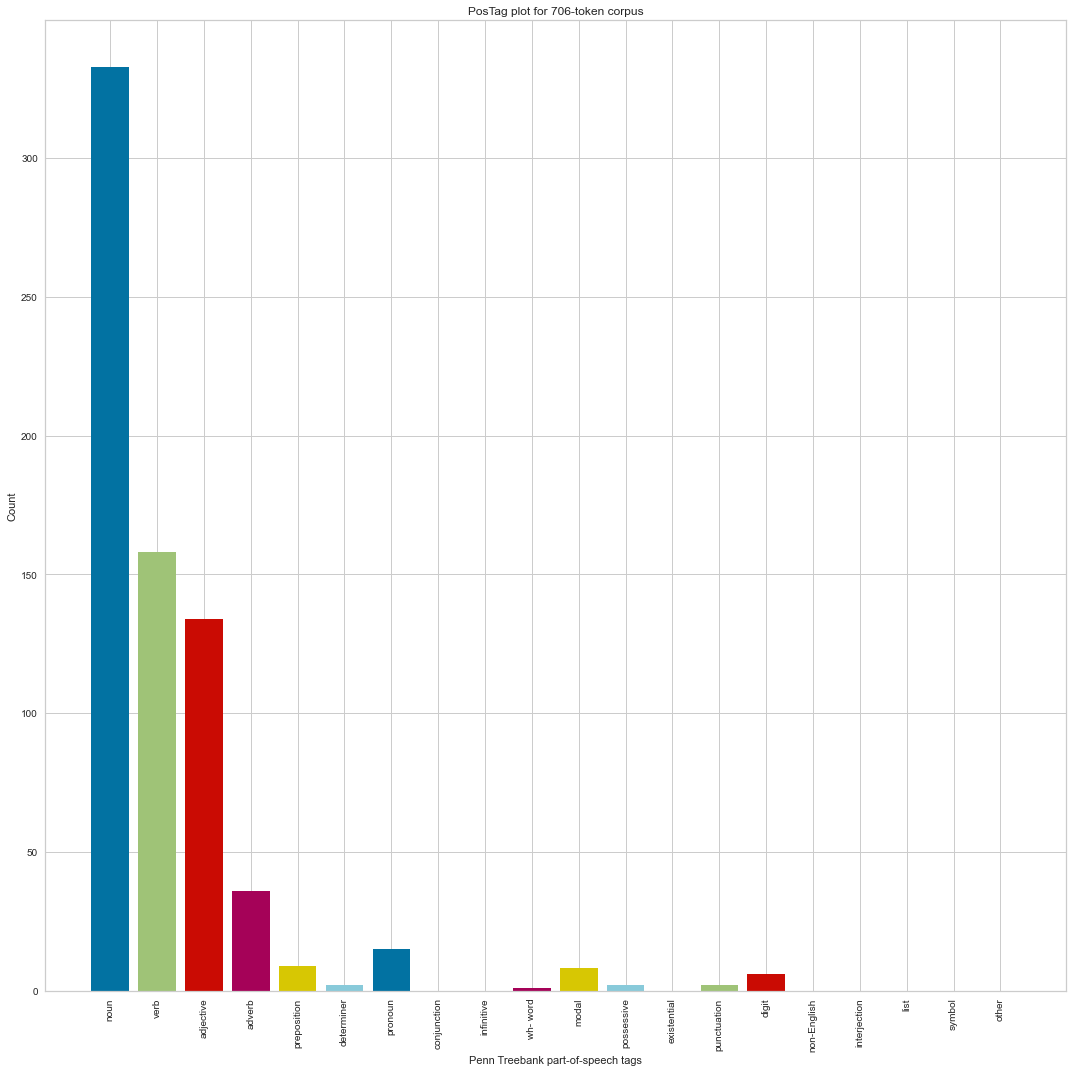

<AxesSubplot:title={'center':'PosTag plot for 706-token corpus'}, xlabel='Penn Treebank part-of-speech tags', ylabel='Count'>

In [81]:
# Create the visualizer for train test

from yellowbrick.text import PosTagVisualizer
plt.figure(figsize=(15,15))
viz = PosTagVisualizer()
viz.fit(tagged_train)
viz.show()

# Text Classification Methodology

In [82]:
# Now let's check if number of examples for fake vs not-fake label is equal or not. Seems like in this case it's very balanced. 

train["Label"].value_counts()

overview            29
attack_execution    20
analysis             8
Name: Label, dtype: int64

<AxesSubplot:xlabel='Label', ylabel='count'>

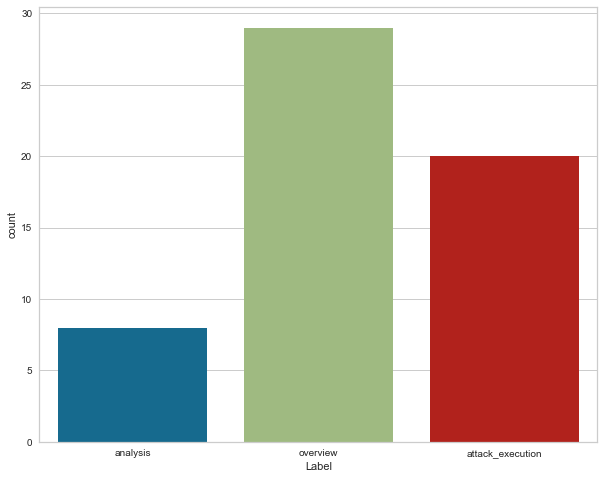

In [83]:
# we see there is an equal number of distribution of target features

rcParams["figure.figsize"] = 10,8
sns.countplot(x = train["Label"])

In [84]:
# lets extract the label column from train dataframe to be the target 'y' variable
targets = train['Label'].values

# Drop the 'label' column from train dataset
train.drop("Label", axis=1, inplace = True)
train.head()

,Writeup_name,Category,Text,Text_tokenize,Text_tokenize_join
4,Members,web,if we leave the search query empty we would se...,"[leave, search, query, empty, would, see, memb...",leave search query empty would see members els...
9,High_Security,web,we have again a login page this time only we c...,"[login, page, time, register, user]",login page time register user
12,27_Forbidden_Paths,web,this website has the useful feature of reading...,"[website, useful, feature, reading, file, want...",website useful feature reading file want given...
13,27_Forbidden_Paths,web,with file paths a preceeding means the curren...,"[file, paths, preceeding, means, current, dire...",file paths preceeding means current directory ...
14,27_Forbidden_Paths,web,since we know that we are in usrsharenginxhtml...,"[since, know, usrsharenginxhtml, want, access,...",since know usrsharenginxhtml want access flagt...


In [85]:
transformer = TfidfTransformer(smooth_idf=False)
count_vectorizer = CountVectorizer(ngram_range=(1, 2))

In [86]:
# fit train data to the count vectorizer
train_counts = count_vectorizer.fit_transform(train['Text'].values)

#fit the ngrams count to the tfidf transformers
train_tfidf = transformer.fit_transform(train_counts)

In [87]:
from sklearn.model_selection import train_test_split

#  If train-test size is not initialized, test_size will be set to 0.25 and train_set = 1-test_size

X_train, X_test, y_train, y_test = train_test_split(train_tfidf, targets, random_state=0)


In [88]:
Extr = ExtraTreesClassifier(n_estimators=5,n_jobs=4)
Extr.fit(X_train, y_train)

print('Accuracy of ExtraTrees classifier on train set: {:.2f}'.format(Extr.score(X_train, y_train)))

print('Accuracy of ExtraTrees classifier on test set: {:.2f}'.format(Extr.score(X_test, y_test)))

Accuracy of ExtraTrees classifier on train set: 1.00
Accuracy of ExtraTrees classifier on test set: 0.53


In [89]:
Adab= AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),n_estimators=5)
Adab.fit(X_train, y_train)

print('Accuracy of Adaboost classifier on training set: {:.2f}'.format(Adab.score(X_train, y_train)))

print('Accuracy of Adaboost classifier on test set: {:.2f}'.format(Adab.score(X_test, y_test)))

Accuracy of Adaboost classifier on training set: 1.00
Accuracy of Adaboost classifier on test set: 0.53


In [90]:
RandomFC= RandomForestClassifier(n_estimators=5)
RandomFC.fit(X_train, y_train)

print('Accuracy of randomforest classifier on training set: {:.2f}'.format(RandomFC.score(X_train, y_train)))

print('Accuracy of randomforest classifier on test set: {:.2f}'.format(RandomFC.score(X_test, y_test)))

Accuracy of randomforest classifier on training set: 1.00
Accuracy of randomforest classifier on test set: 0.60


In [91]:
from sklearn.naive_bayes import MultinomialNB

NB = MultinomialNB()
NB.fit(X_train, y_train)

print('Accuracy of NB  classifier on training set: {:.2f}'.format(NB.score(X_train, y_train)))

print('Accuracy of NB classifier on test set: {:.2f}'.format(NB.score(X_test, y_test)))

Accuracy of NB  classifier on training set: 0.83
Accuracy of NB classifier on test set: 0.47


In [93]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(C=1e5)
logreg.fit(X_train, y_train)

print('Accuracy of Logreg classifier on training set: {:.2f}'.format(logreg.score(X_train, y_train)))

print('Accuracy of Logreg classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of Logreg classifier on training set: 1.00
Accuracy of Logreg classifier on test set: 0.67


## Measuring Model Performance

In [94]:
# Use score method to get accuracy of model
score = logreg.score(X_test, y_test)
print(score)

0.6666666666666666


In [95]:
# Predict and calculate accuracy
from sklearn.metrics import accuracy_score

predictions = logreg.predict(X_test)
score=accuracy_score(y_test,predictions)
print(f'Accuracy: {round(score*100,2)}%')

Accuracy: 66.67%


In [96]:
from sklearn import metrics

CM = metrics.confusion_matrix(y_test, predictions)
print(CM)

[[3 5]
 [0 7]]


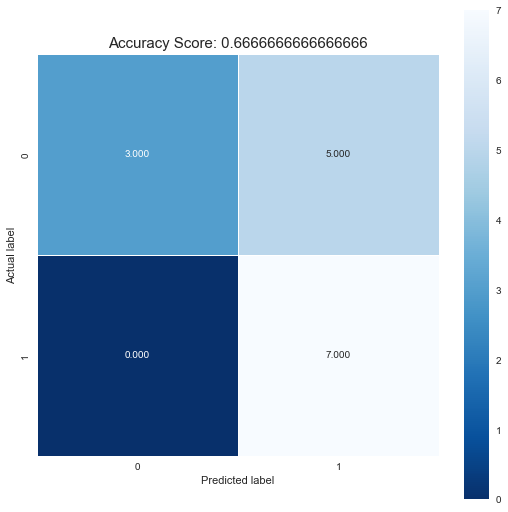

In [97]:
plt.figure(figsize=(9,9))
sns.heatmap(CM, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

### From the confusion matrix we can make the following conclusions:

- Our model successfully predicted 3 positives
- Our model successfully predicted 7 negatives.
- Our model predicted 5 false positives
- Our model predicted 0 false negatives
